This note boo is taken from this tutorial https://jaketae.github.io/study/word2vec/ on implementing word2vec from scratch

In [15]:
import pandas as pd
import numpy as np

In [16]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [17]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms'''

### Tokenization

In [18]:
import re
from string import punctuation 

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    '''create a map between tokens and indices'''
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word


In [19]:
tokens = tokenize(text)

In [20]:
word_to_idex, idex_to_word = mapping(tokens)
word_to_idex

{'that': 0,
 'is': 1,
 'improve': 2,
 'algorithms': 3,
 'through': 4,
 'machine': 5,
 'study': 6,
 'experience': 7,
 'subset': 8,
 'of': 9,
 'a': 10,
 'artificial': 11,
 'computer': 12,
 'the': 13,
 'learning': 14,
 'as': 15,
 'seen': 16,
 'intelligence': 17,
 'it': 18,
 'automatically': 19}

### Generate training Data
- We know tokens are strings, we need to encode them numerically using one-hot vectorization. 
- We also need to generate the input and target values.
- we need to also create the context of each word

In [26]:
np.random.seed(42)


def generate_training_data(tokens, word_to_idex, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_idex[tokens[i]], len(word_to_idex)))
            y.append(one_hot_encode(word_to_idex[tokens[j]], len(word_to_idex)))
    
    return np.asarray(X), np.asarray(y)


def concat(*iterables):
    for iterable in iterables:
        yield from iterable


def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res


In [35]:
X, y = generate_training_data(tokens, word_to_idex, 2)

In [36]:
X.shape

(94, 20)

In [37]:
y.shape

(94, 20)

In [34]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
The representation we will use for the model is a Python dictionary, whose values are the weight matrices and keys, the name with which we will refer to the weight matrices "W1" and "W2" to refer to these weights.

Both X and y are matrices with 330 rows and 60 columns. 
- 330 is the number of training examples we have (this number to have been larger had we used a larger window).
- 60 is the size of our corpus, or the number of unique tokens we have in the original text.  
Since we have one-hot encoded both the input and output as 60-dimensional sparse vectors, this is expected.

### Embedding Model

The representation we will use for the model is a Python dictionary, whose values are the weight matrices and keys, the name with which we will refer to the weight matrices "W1" and "W2" to refer to these weights.

In [38]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model


In [40]:
model = init_network(len(word_to_idex), 10)
model

{'w1': array([[-1.59442766, -0.59937502,  0.0052437 ,  0.04698059, -0.45006547,
          0.62284993, -1.06762043, -0.14237949,  0.12029563,  0.51443883],
        [ 0.71161488, -1.12464209, -1.53411417,  1.27767682,  0.33231401,
         -0.74848654,  1.55115198,  0.11567463,  1.17929718,  0.06751848],
        [ 2.06074792,  1.75534084, -0.24896415,  0.97157095,  0.64537595,
          1.36863156, -0.96492346,  0.68605146,  1.05842449, -1.75873949],
        [-1.18325851, -2.03923218, -0.26940683,  0.71754226,  1.50235705,
          0.07409478,  1.62861555, -1.38010146, -1.70338244, -0.0555477 ],
        [ 0.38406545, -0.03269475, -2.0674421 , -0.08912004, -1.3044695 ,
          0.66967255,  0.36659825, -0.93987979, -0.51386692, -1.05921352],
        [-0.0626791 ,  0.95514232, -0.98572605,  0.50404652, -0.53025762,
         -0.79287283, -0.10703036, -1.03524232, -0.55364931, -1.19787789],
        [ 1.96472513,  0.03526355, -0.69972551,  0.21397991, -0.11232805,
         -0.2209696 ,  0.6

### Forward Propagation

In [45]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    
    return cache

In [46]:
# check the dimensionality of the matrices
(X @ model["w1"]).shape

(94, 10)

All the 330 tokens in the text to be converted into 10-dimensional vectors

In [47]:
# check the dimensionality after passing through the second layer
(X @ model["w1"] @ model["w2"]).shape

(94, 20)

### Backpropagation

In [48]:
def backward(model, X, y, alpha):
    
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    
    return cross_entropy(cache["z"], y)


In [49]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

### training the model

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

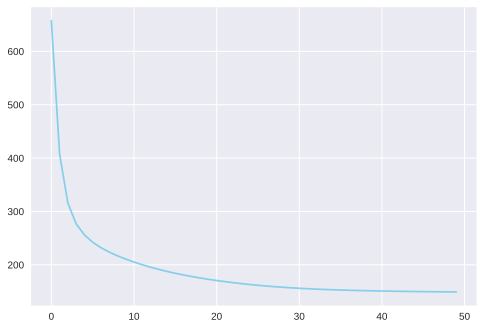

In [51]:
n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

We can perform sanity to see which token our model predicts given the word “learning.”

In [52]:
learning = one_hot_encode(word_to_idex["learning"], len(word_to_idex))
result = forward(model, [learning], return_cache=False)[0]

for word in (idex_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)


machine
algorithms
intelligence
the
is
it
learning
automatically
study
computer
as
of
artificial
a
through
that
improve
experience
seen
subset


In [53]:
learning

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [54]:
len(learning)

20